In [86]:
#beria ayşenur can 090200705

### Intuition of Quantile Loss 

Typical Loss Function:

$$ L = (y - X\theta)^2 $$

Quantile Loss:

$$
\begin{equation}
  L =
    \begin{cases}
      \tau (y - X\theta) & \text{if $y - X\theta\ge 0$}\\
      (\tau - 1) (y - X\theta) & \text{if $y - X\theta < 0$ }\\
    \end{cases}       
\end{equation}
$$

We want to penilze loss if:
- the percentile $\tau$ is low, but the prediction $X\theta$ is high
- the percentile $\tau$ is high, but the prediction $X\theta$ is low

### Problem

In [87]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression,QuantileRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [88]:
from sklearn.utils.fixes import parse_version, sp_version

# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [89]:
life_exp = pd.read_csv('datasets/life_expectancy.csv', na_values='')

In [90]:
life_exp.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [91]:
life_exp.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [92]:
# Cleaning column names to make them Python-friendly (snake_case)
life_exp.columns = life_exp.columns.str.lower().str.replace(' ', '_')
life_exp.columns

Index(['country', 'year', 'status', 'life_expectancy_', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles_', '_bmi_', 'under-five_deaths_', 'polio', 'total_expenditure',
       'diphtheria_', '_hiv/aids', 'gdp', 'population',
       '_thinness__1-19_years', '_thinness_5-9_years',
       'income_composition_of_resources', 'schooling'],
      dtype='object')

In [93]:
# Removing rows with any missing values
life_exp_narm = life_exp.dropna()

In [94]:
# Filtering out rows where income_composition_of_resources is around 0
life_exp_narm = life_exp_narm[life_exp_narm['income_composition_of_resources'] > 0]

In [95]:
# Renaming a column
life_exp_narm.rename(columns={'income_composition_of_resources': 'income_index'}, inplace=True)


In [96]:
# Specifying the features and target for prediction
X = life_exp_narm['income_index']
y = life_exp_narm['life_expectancy_']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes of the train and test sets to confirm the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1280,), (321,), (1280,), (321,))

In [97]:
# Descriptive statistics and standard deviation for 'income_index'
print(X_train.describe())
print(X_train.std())

count    1280.000000
mean        0.652577
std         0.150366
min         0.279000
25%         0.533000
50%         0.679000
75%         0.758000
max         0.936000
Name: income_index, dtype: float64
0.15036585652214324


In [98]:
# Descriptive statistics and standard deviation for 'income_index'
print(y_train.describe())
print(y_train.std())

count    1280.000000
mean       69.434766
std         8.948837
min        44.000000
25%        64.700000
50%        71.800000
75%        75.100000
max        89.000000
Name: life_expectancy_, dtype: float64
8.948836542969229


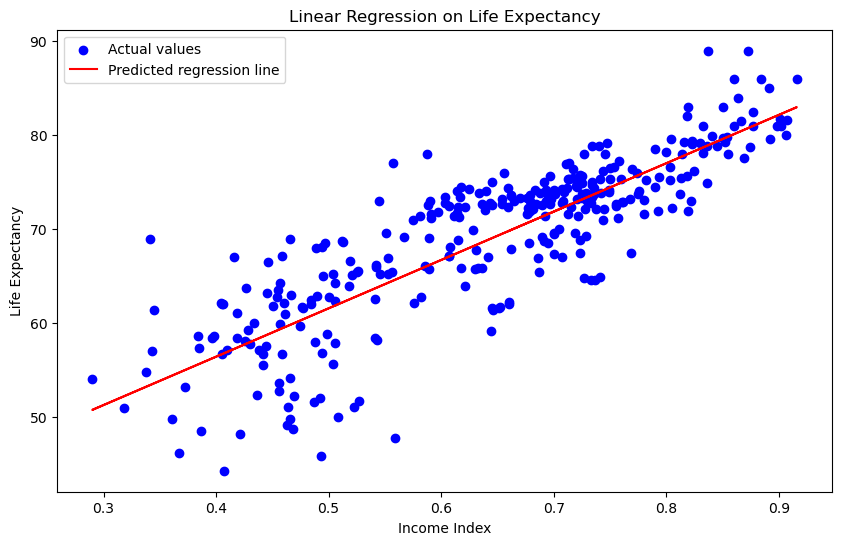

In [99]:
# Specifying the features and target for prediction
X = life_exp_narm[['income_index']]  # Modifying to ensure X is 2D
y = life_exp_narm['life_expectancy_']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
linear_model = LinearRegression()

# Fitting the model with training data
linear_model.fit(X_train, y_train)

# Predicting on test data
y_pred = linear_model.predict(X_test)

# Now we plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual values')
plt.plot(X_test, y_pred, color='red', label='Predicted regression line')
plt.title('Linear Regression on Life Expectancy')
plt.xlabel('Income Index')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()


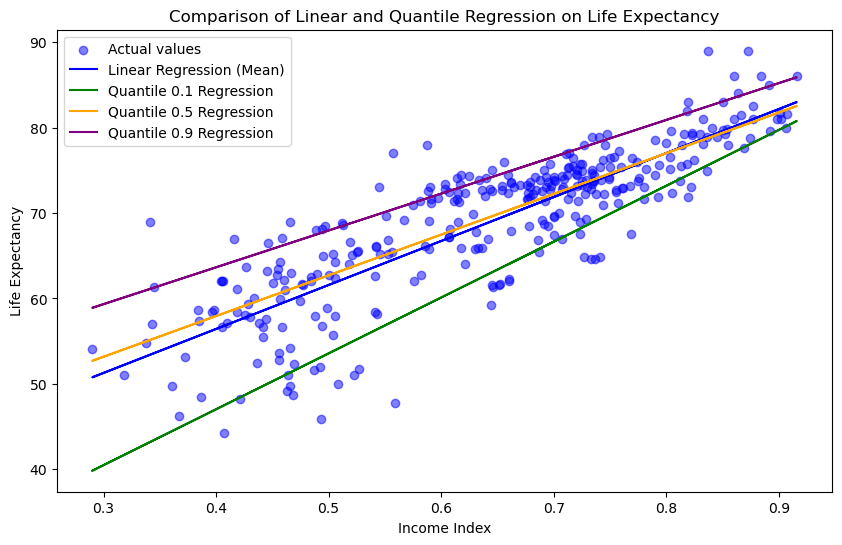

In [100]:
# Creating QuantileRegressor models for different quantiles
quantile_models = {
    0.1: QuantileRegressor(quantile=0.1,alpha=0, solver=solver).fit(X_train, y_train),
    0.5: QuantileRegressor(quantile=0.5,alpha=0, solver=solver).fit(X_train, y_train),  # Median regression
    0.9: QuantileRegressor(quantile=0.9,alpha=0, solver=solver).fit(X_train, y_train)
}

# Predictions for each quantile
quantile_predictions = {q: model.predict(X_test) for q, model in quantile_models.items()}

# Plotting the results along with linear regression
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual values', alpha=0.5)
plt.plot(X_test, y_pred, color='blue', label='Linear Regression (Mean)')

colors = {0.1: 'green', 0.5: 'orange', 0.9: 'purple'}
for q, preds in quantile_predictions.items():
    plt.plot(X_test, preds, color=colors[q], label=f'Quantile {q} Regression')

plt.title('Comparison of Linear and Quantile Regression on Life Expectancy')
plt.xlabel('Income Index')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()

In [101]:
# Redefine Linear Regression and Quantile Regressor models and reinitialize calculations
linear_model = LinearRegression()
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}
quantile_predictions = {}
errors = {}

# Fit Linear Regression model
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Fit Quantile Regressors and calculate errors
for q in quantiles:
    model = QuantileRegressor(quantile=q, alpha=0, solver=solver)
    model.fit(X_train, y_train)
    y_pred_quantile = model.predict(X_test)
    quantile_models[q] = model
    quantile_predictions[q] = y_pred_quantile
    errors[q] = {
        "MSE": mean_squared_error(y_test, y_pred_quantile),
        "MAE": mean_absolute_error(y_test, y_pred_quantile)
    }

# Errors for Linear Regression
errors["linear"] = {
    "MSE": mean_squared_error(y_test, y_pred_linear),
    "MAE": mean_absolute_error(y_test, y_pred_linear)
}

errors

{0.1: {'MSE': 66.35143541816436, 'MAE': 6.875029954469206},
 0.5: {'MSE': 21.66743129432068, 'MAE': 3.439830515787748},
 0.9: {'MSE': 46.25876686658076, 'MAE': 5.260552395141989},
 'linear': {'MSE': 21.559950192259286, 'MAE': 3.5621439857474053}}

In [102]:
# Using cross-validation to estimate the error for Linear Regression
cv_scores_linear = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_linear = -cv_scores_linear.mean()

# Using cross-validation to estimate the error for Quantile Regression at median
cv_scores_quantile_median = cross_val_score(QuantileRegressor(quantile=0.5, alpha=0, solver=solver), X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_quantile_median = -cv_scores_quantile_median.mean()

# Displaying cross-validated errors
print("Cross-validated Mean Squared Error for Linear Regression:", cv_mse_linear)
print("Cross-validated Mean Squared Error for Median Quantile Regression:", cv_mse_quantile_median)

Cross-validated Mean Squared Error for Linear Regression: 21.517842773389425
Cross-validated Mean Squared Error for Median Quantile Regression: 21.93363596892265


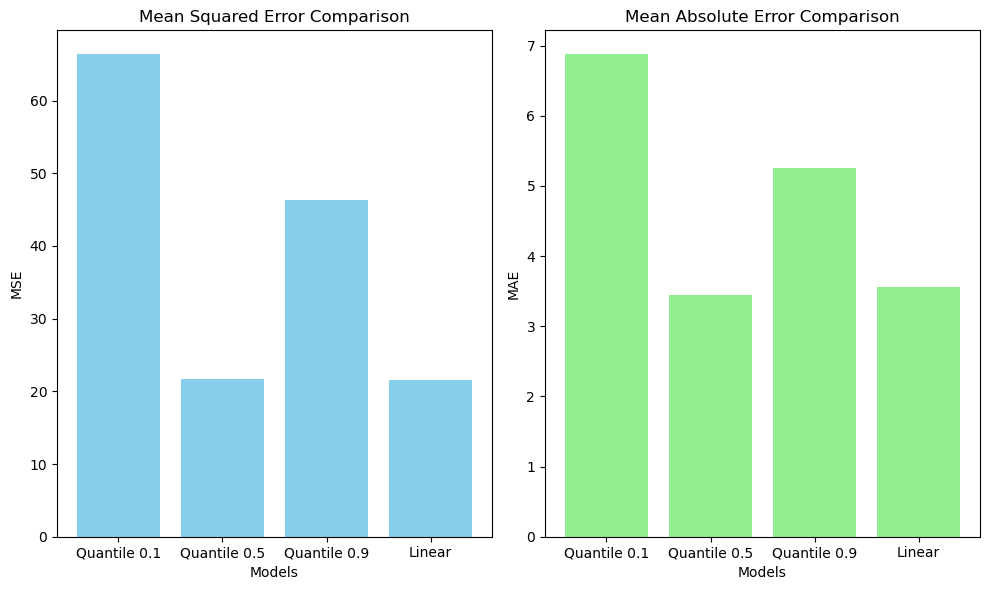

In [103]:
# Extracting MSE and MAE values for plotting
mse_values = [errors[q]['MSE'] for q in errors]
mae_values = [errors[q]['MAE'] for q in errors]
labels = ['Quantile 0.1', 'Quantile 0.5', 'Quantile 0.9', 'Linear']

# Creating the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Plotting MSE
ax[0].bar(labels, mse_values, color='skyblue')
ax[0].set_title('Mean Squared Error Comparison')
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('Models')

# Plotting MAE
ax[1].bar(labels, mae_values, color='lightgreen')
ax[1].set_title('Mean Absolute Error Comparison')
ax[1].set_ylabel('MAE')
ax[1].set_xlabel('Models')

plt.tight_layout()
plt.show()

## CONCLUSION

In many prediction problems, you might need to think beyond the mean. Quantile regression is a very powerful tool for that, as it allows you to approximate any percentile of the distribution, and therefore provides you a more comprehensive analysis of the relationship between variables.